<a href="https://colab.research.google.com/github/RevanthBN/Iris-Pupil-Segmentation/blob/main/Iris_seg_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google drive and cloning the github repo!**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Iris-Pupil-Segmentation/
!git pull

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Iris-Pupil-Segmentation
Already up to date.


**Import all that is needed!**

In [2]:
# Global libraries
import os
from glob import glob

# Python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torch.nn.functional as F
import math

# Image processing
import cv2
from PIL import Image

# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader

# Others
import time
from sklearn.metrics import mean_absolute_error
cuda = torch.cuda.is_available()

**Additional global variables**



In [3]:
# Path for the training set
train_images_path = glob('training_set/images/*')
train_groundtruth_path = glob('training_set/groundtruths/*')
train_masks_path = glob('training_set/masks/*')

# Path for the test set
test_images_path = glob('testing_set/images/*')
test_groundtruth_path = glob('testing_set/groundtruths/*')
test_masks_path = glob('testing_set/masks/*')

# Image sizes for resizing
width = 256
height = 256
dim = (width, height)

**Hyperparameters to be tuned**

In [4]:
# Percentage for the train-val split
val_percent = 0.3

# Number of workers for dataloader
num_workers = 4 if cuda else 0 

# Batch size during training
batch_size = 10

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers 0.01
lr = 1e-2

# Checkpoint path
checkpoint_path = "files_v3/checkpoint.pth"


**Loading the dataset from the cloned drive folder**

In [5]:
class Iris(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        # Reading image 
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image/255.0 ## (256, 256, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Reading mask 
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        mask = mask/255.0 ## (256, 256, 3)
        mask = np.transpose(mask, (2, 0, 1))  ## (3, 256, 256)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

**Creating the datasets**

In [6]:
# Creating the datasets 
train_dataset = Iris(train_images_path, train_masks_path)
test_set = Iris(test_images_path, test_masks_path)

**Splitting the train dataset into Training and Validation sets by a 70-30 split with a manual seed of 0**

In [7]:
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data_str = f"Dataset Size:\nTrain: {len(train_set)} - Validation: {len(val_set)} - Test: {len(test_set)}\n"
print(data_str)

Dataset Size:
Train: 379 - Validation: 162 - Test: 10



**Loading the dataloader for the datasets**

In [8]:
# Training data
train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train_set, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = DataLoader(test_set, **test_loader_args)


**Dice Loss Function** 

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# class DiceCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         CE = F.cross_entropy(inputs, targets, reduction='mean')
#         Dice_CE = CE + dice_loss

#         return Dice_CE


**Model definition**

In [10]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [11]:
device = torch.device("cuda" if cuda else "cpu")
model = build_unet()
# model = smp.Unet('resnet34', encoder_weights="imagenet", classes=3, activation='softmax')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(0.3*num_epochs), gamma=0.1)
loss_fn = DiceLoss()
model = model.to(device)

**Utility Functions**

In [12]:
# Calculate the time taken 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training and Validation Functions**

In [13]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Training")
    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Evaluation")
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

**Training and Evaluation of the model**

In [ ]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [14]:
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, val_loader, loss_fn, device)

    # Saving the model
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Entered Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Entered Evaluation
Valid loss improved from inf to 0.5578. Saving checkpoint: files_v3/checkpoint.pth
Epoch: 01 | Epoch Time: 1m 49s
	Train Loss: 0.419
	 Val. Loss: 0.558

Entered Training
Entered Evaluation
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.215
	 Val. Loss: 0.639

Entered Training
Entered Evaluation
Valid loss improved from 0.5578 to 0.1823. Saving checkpoint: files_v3/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.164
	 Val. Loss: 0.182

Entered Training
Entered Evaluation
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.128
	 Val. Loss: 0.262

Entered Training
Entered Evaluation
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.123
	 Val. Loss: 0.189

Entered Training
Entered Evaluation
Valid loss improved from 0.1823 to 0.1096. Saving checkpoint: files_v3/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.104
	 Val. Loss: 0.110

Entered Training
Entered Evaluation
Epoch: 07 | Epoch Time: 0m 13s
	Train Loss: 0.102
	 Val. Loss: 0.204

Entered Training
Ent

**Testing function**

In [15]:
def predict(model, loader, loss_fn, device):
    epoch_loss = 0
    y_preds = []
    print("Entered Evaluation")
    with torch.no_grad():
        model.eval()
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            y_preds.append(y_pred)
        epoch_loss = epoch_loss/len(loader)
    return epoch_loss, y_preds


In [16]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
test_loss, pred_masks = predict(model, test_loader, loss_fn, device)

Entered Evaluation


**Visualization of the results**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

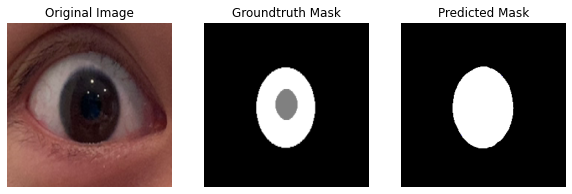

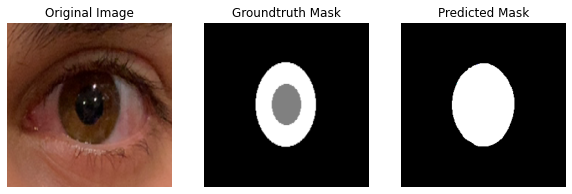

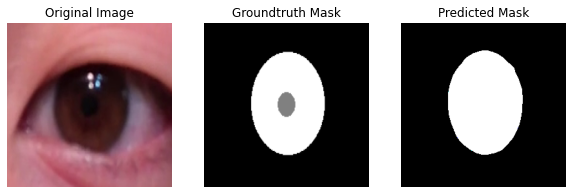

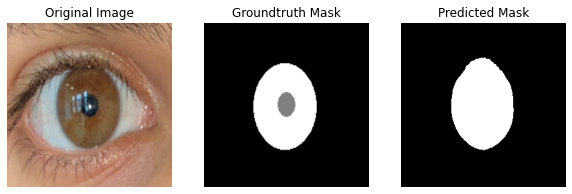

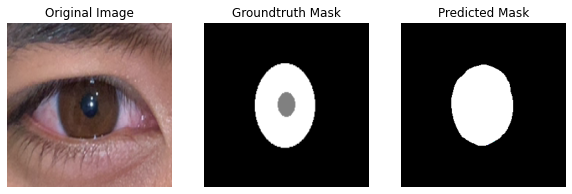

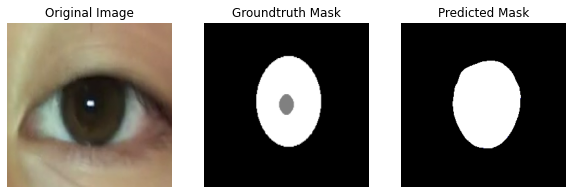

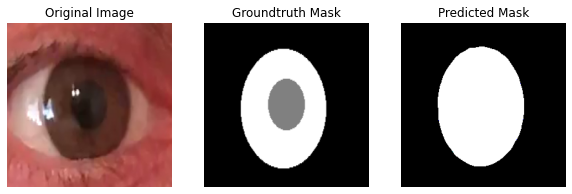

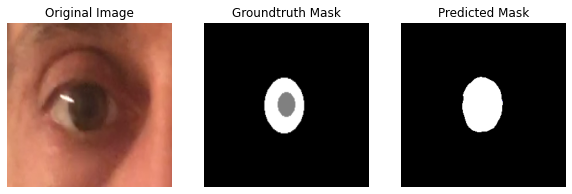

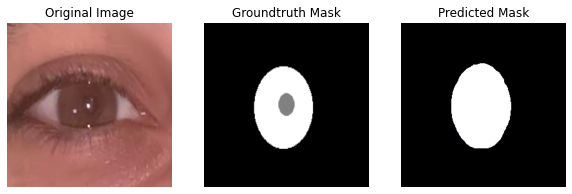

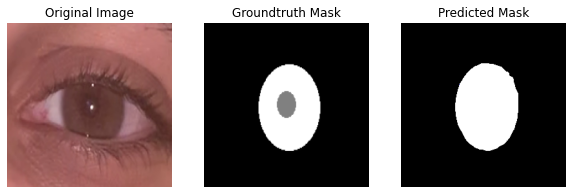

In [20]:
# len(test_set)
for i in range(len(test_set)):
  # Processing the original image
  test_original = test_set[i][0].cpu().numpy()
  test_original = np.squeeze(test_original) 
  test_original = np.transpose(test_original, (1, 2, 0))

  
  # Processing the groundtruth mask
  test_image = test_set[i][1].cpu().numpy()
  test_image = np.squeeze(test_image) 
  test_image = np.transpose(test_image, (1, 2, 0))

  # Processing the predicted mask
  pred_m = pred_masks[i].cpu().numpy()
  pred_m=np.squeeze(pred_m) 
  pred_m = np.transpose(pred_m, (1, 2, 0))   
  pred_m_resized=cv2.resize(pred_m, (224,160));
  pred_m1=pred_m_resized*255
  file_path = "testing_set/pred_masks/pred_im" + str(i) + ".png"
  cv2.imwrite(file_path, pred_m1)

  # Visuzalizing the predicted masks and actual masks alongside the original images
  plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(test_original);
  plt.axis("off")
  plt.title("Original Image")
  plt.subplot(1,3,2)
  plt.imshow(test_image, cmap='gray');
  plt.axis("off")
  plt.title("Groundtruth Mask")
  plt.subplot(1,3,3)
  plt.imshow(pred_m*255, cmap='gray')
  plt.axis("off")
  plt.title("Predicted Mask")

  

**Evaluation Metrics - Compute the Average Iris diameter accuracy**


In [17]:
print("The Dice score is: "+str(1-test_loss))

The Dice score is: 0.9401770114898682


**Estimate the Iris Diameter**

In [40]:
pred_masks_path = glob('testing_set/pred_masks/*')
pred_iris_dia = []
for pred_mask in pred_masks_path:

  imgG = cv2.imread(pred_mask, 0)
  imgO = cv2.imread(file_path)
  # print(imgG.shape)

  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the Iris diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      # print("No circles found")
      pred_iris_dia.append(80)
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")
      
      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          # print("The x,y coordinates of iris are: ("+str(x)+","+str(y)+")")
          # print("The diameter of the iris is: "+str(r*2))
          pred_iris_dia.append(r*2)

In [36]:
gt_masks_path = glob('testing_set/masks/*')
gt_iris_dia = []
for gt_mask in gt_masks_path:

  imgG = cv2.imread(gt_mask, 0)
  # print(imgG.shape)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the Iris diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      # print("No circles found")
      pass
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          # print("The x,y coordinates of iris are: ("+str(x)+","+str(y)+")")
          # print("The diameter of the iris is: "+str(r*2))
          gt_iris_dia.append(r*2)

**Estimate the Pupil Diameter**

In [45]:
pred_masks_path = glob('testing_set/pred_masks/*')
pred_pupil_dia = []
for pred_mask in pred_masks_path:

  imgG = cv2.imread(pred_mask, 0)
  print(imgG.shape)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the pupil diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      pred_pupil_dia.append(10*2)
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of pupil are: ("+str(x)+","+str(y)+")")
          print("The diameter of the pupil is: "+str(r*2))
          pred_pupil_dia.append(r*2)
          cv2.imwrite("houghOutput.png", imgG)

(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)
(160, 224)


In [46]:
gt_masks_path = glob('testing_set/masks/*')
gt_pupil_dia = []
for gt_mask in gt_masks_path:

  imgG = cv2.imread(gt_mask, 0)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the pupil diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      gt_pupil_dia.append(10*2)
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of pupil are: ("+str(x)+","+str(y)+")")
          print("The diameter of the pupil is: "+str(r*2))
          gt_pupil_dia.append(r*2)
          # cv2.imwrite("houghOutput.png", imgG)

The x,y coordinates of pupil are: (112,80)
The diameter of the pupil is: 30
The x,y coordinates of pupil are: (110,78)
The diameter of the pupil is: 40
The x,y coordinates of pupil are: (110,80)
The diameter of the pupil is: 24
The x,y coordinates of pupil are: (110,80)
The diameter of the pupil is: 24
The x,y coordinates of pupil are: (110,80)
The diameter of the pupil is: 24
The x,y coordinates of pupil are: (112,80)
The diameter of the pupil is: 18
The x,y coordinates of pupil are: (110,80)
The diameter of the pupil is: 24
The x,y coordinates of pupil are: (112,80)
The diameter of the pupil is: 20
The x,y coordinates of pupil are: (112,80)
The diameter of the pupil is: 24


In [47]:
# Predicted diameters
p_iris=np.array(pred_iris_dia)
print(p_iris)
p_pupil=np.array(pred_pupil_dia)
# Groundtruth diameters
gt_iris=np.array(gt_iris_dia)
gt_pupil=np.array(gt_pupil_dia)

[80 80 88 54 82 98 82 84 84 82]


**Mean % Iris Diameter Error**

In [48]:
m = np.mean((abs(p_iris-gt_iris)/gt_iris) * 100)
ans = f'Mean Absolute % Iris diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Iris diameter error is: 20.143 %



**Mean % Pupil Diameter Error**

In [49]:
m = np.mean((abs(p_pupil-gt_pupil)/gt_pupil) * 100)
ans = f'Mean Absolute % Pupil diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Pupil diameter error is: 17.778 %



In [ ]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address
